In [6]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy
from matplotlib import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.decomposition import FastICA, PCA
N = 1000
alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)
z = np.ones(N)

RI_pres = np.random.rand(D, N)
RI_pres = np.where(RI_pres>0.5, 1, -1)

RI_past = np.random.rand(D, N)
RI_past = np.where(RI_past>0.5, 1, -1)

def read_csv(filepath):
    category2word = {}
    category2freqdist = {}
    key = 0
    present, past, weights = [], [], []
    num_words = 0
    with open(filepath, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if row[0] == "#":
                category2word[key] = [present, past]
                
                weights = np.asarray(weights)
                # true probability is weights/np.sum(weights,axis=0). 
                # 1 - is to emphasize smaller freqs. idk 
                weights = 1-weights/np.sum(weights,axis=0)
                # force sum to 1
                weights = weights/np.sum(weights,axis=0)

                category2freqdist[key] = weights
                
                #category2freqdist[key] = normalize(np.array(weights), axis=1)
                key += 1;
                present, past, weights = [], [], []
                
            else:
                present.append(row[0])
                past.append(row[1])
                weights.append(float(row[2]))
            num_words += 1
    return category2word, category2freqdist, num_words

def ngram_encode(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)     
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1

def sample(X, category_size, freqdist, mu, sigma):
    num_samples = category_size - X.shape[0]
    X_filled = np.zeros((category_size, N))
    X_filled[:X.shape[0]] = X
    X_filled[X.shape[0]:] = X[np.random.choice(X.shape[0], num_samples, freqdist)] + \
    np.random.normal(mu, sigma, (num_samples, N))
    return X_filled

def gen_diffs(present, past, RI_pres, RI_past, ngram_length):
    X = np.zeros((len(past), N))
    for i in range(X.shape[0]):
        X[i] = (ngram_encode(past[i], RI_past, ngram_length) 
                        - ngram_encode(present[i], RI_pres, ngram_length))
    return X

In [2]:
words = open("data/cleaned/latent_space.txt","r").read().split()

In [3]:
category2word, category2freqdist, num_words = read_csv("data/cleaned/irregular_verbs_final_categorize.csv")

In [4]:
available_colors = ['green', 'red', 'blue', 'yellow', 'black']
# looking only at category 0, 1
selected_categories = [0, 1, 2]
num_diffs = 0
past = []
for c in selected_categories:
    num_diffs += len(category2word[c][0])
    past += category2word[c][1]
data_matrix = np.zeros((num_diffs, N))
ngram_lengths = [2, 3, 4]

('green', ['beaten', 'fit', 'set', 'spread', 'hit', 'cut', 'put', 'thrust', 'bid'])
('red', ['built', 'sent', 'spent', 'bent', 'lent'])
ngram_length 3


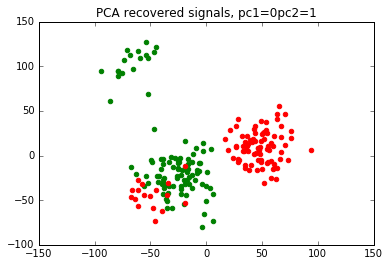

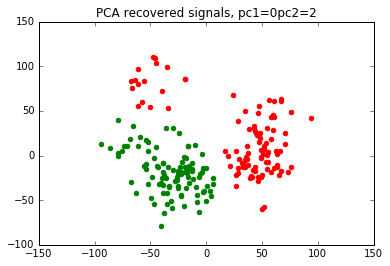

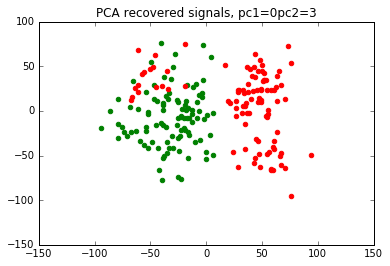

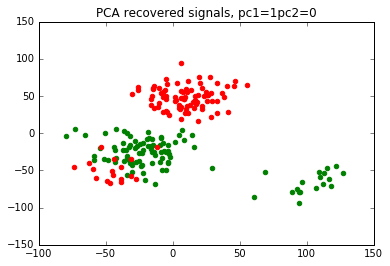

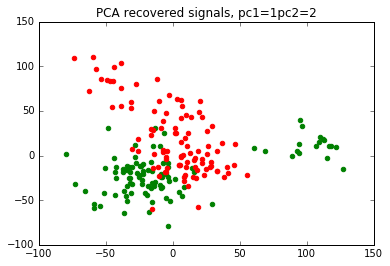

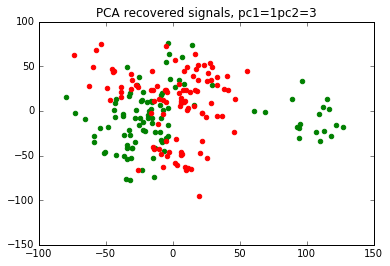

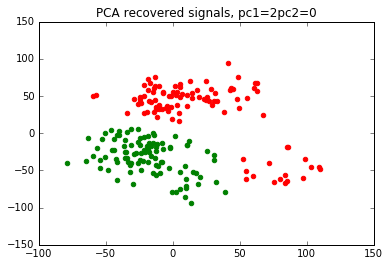

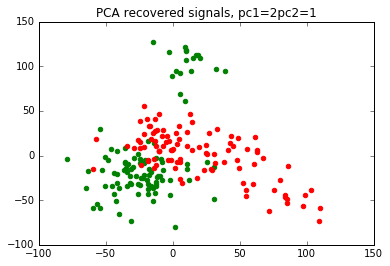

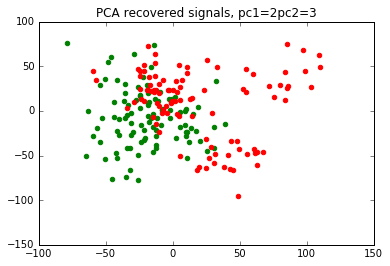

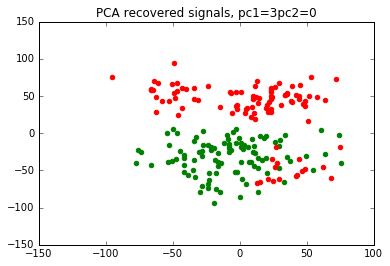

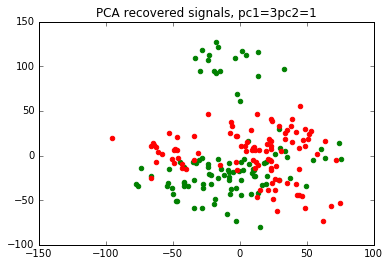

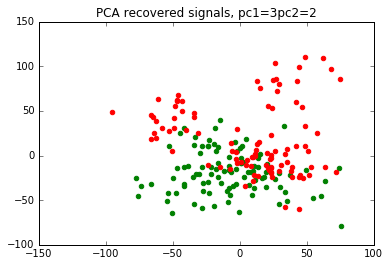

In [15]:
"""
WITH SAMPLING
4th dimension. 
Plot pairs of principle components.
"""
# add more data points by resampling + noise
# make the categories equal size
available_colors = ['green', 'red', 'blue', 'yellow', 'black']
# looking only at category 0, 1
selected_categories = [0, 1]
category_size = 100
ngram_lengths = [3]
num_comps = 4
mu = 0
sigma = 10

num_diffs = 0

for c in selected_categories:
    print (available_colors[c],category2word[c][1]) 
    
X = np.zeros((category_size*len(selected_categories), N))

for ngram_length in ngram_lengths:
    print "ngram_length %d" % ngram_length
    # Generate observations
    for c in selected_categories:
        num_subwords = len(category2word[c][0])
        
        X_cat = gen_diffs(category2word[c][0], category2word[c][1], RI_pres, RI_past, ngram_length)
        X_cat_filled = sample(X_cat, category_size, category2freqdist, mu, sigma)
        X[c*category_size:(c+1)*category_size] = X_cat_filled
        
    
    pca = PCA(n_components=num_comps)
    S_pca_ = pca.fit(X).transform(X)
            
    # 2d
    for pc1 in range(num_comps):
        for pc2 in range(num_comps):
            if pc1 != pc2:
                plt.figure()
                for c in selected_categories:
                    plt.scatter(S_pca_[c*category_size:(c+1)*category_size,pc1], \
                               S_pca_[c*category_size:(c+1)*category_size,pc2], color=available_colors[c])
                plt.title('PCA recovered signals, pc1=' + str(pc1) + ', pc2=' + str(pc2))
                plt.show()

ngram_length 2
(30, 1000)
((30, 30), (30,), (1000, 1000))
(30, 2) (2, 2) (2, 1000) (2, 1000)
(30, 3) (3, 3) (3, 1000) (3, 1000)


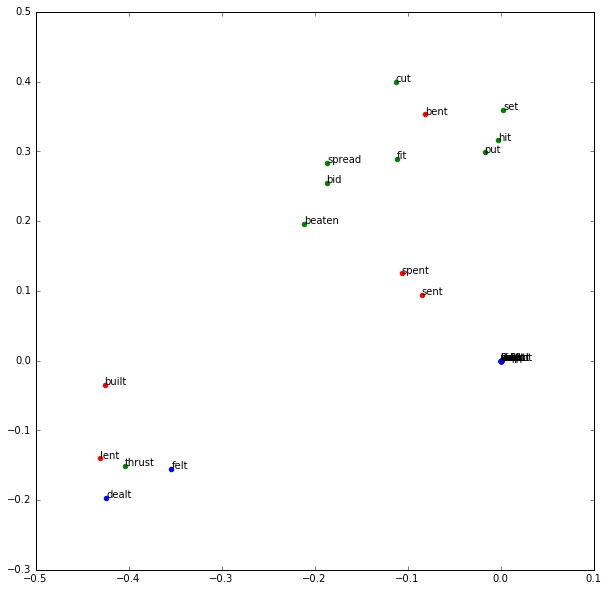

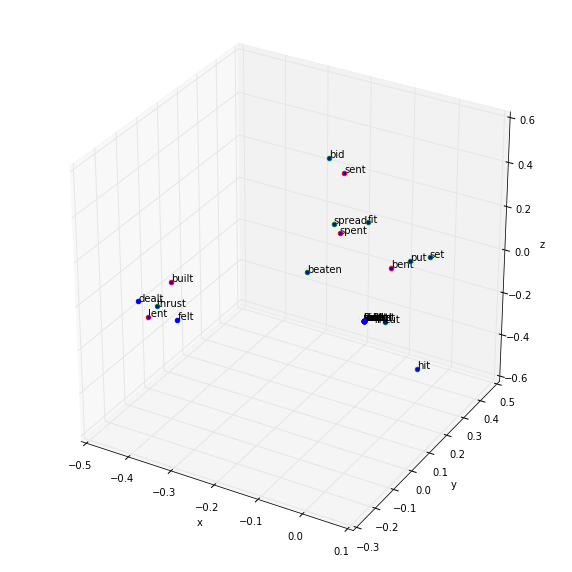

ngram_length 3
(30, 1000)
((30, 30), (30,), (1000, 1000))
(30, 2) (2, 2) (2, 1000) (2, 1000)
(30, 3) (3, 3) (3, 1000) (3, 1000)


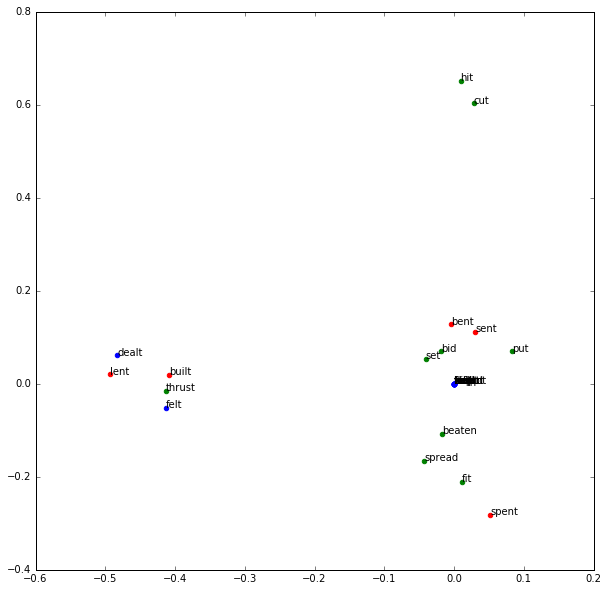

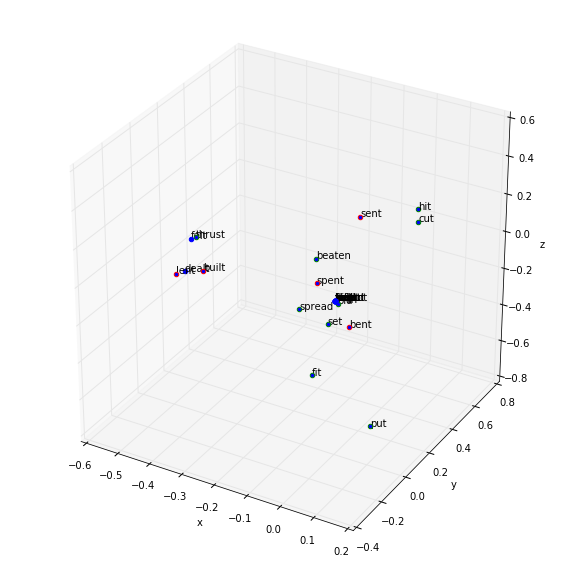

ngram_length 4
(30, 1000)
((30, 30), (30,), (1000, 1000))
(30, 2) (2, 2) (2, 1000) (2, 1000)
(30, 3) (3, 3) (3, 1000) (3, 1000)


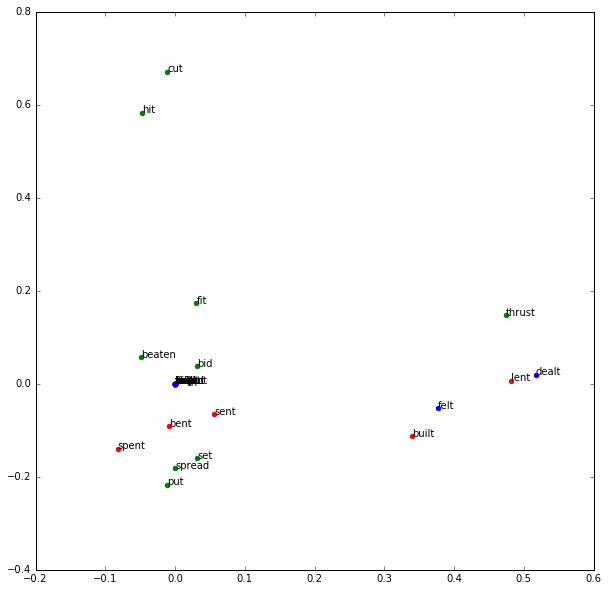

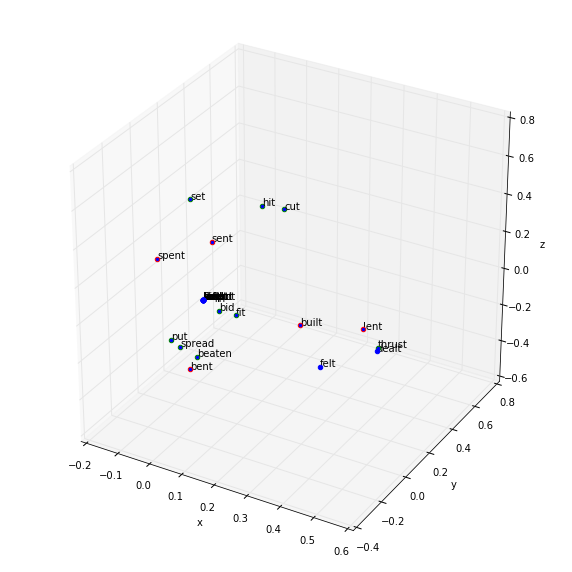

In [50]:
for ngram_length in ngram_lengths:
    print "ngram_length %d" % ngram_length
    for c in selected_categories:
        num_subwords = len(category2word[c][0])
        for i in range(num_subwords):
            data_matrix[i] = ngram_encode_cl(category2word[c][1][i], RI_past, ngram_length) - ngram_encode_cl(category2word[c][0][i], RI_pres, ngram_length)
    print data_matrix.shape
    
    ds = [2, 3]

    U, s, V = np.linalg.svd(data_matrix, full_matrices=True)
    print (U.shape, s.shape, V.shape) 
    pca_data = []
    
    for d in ds:
        Ud = U[:, :d]
        Sd = s[:d]*np.eye(d)
        Vd = V[:d, :]
        SdVd = np.dot(Sd, Vd)
        print Ud.shape, Sd.shape, Vd.shape, SdVd.shape
        pca_data.append(Ud)
    
    # 2d
    fig, ax = plt.subplots(figsize=(10,10))
    i = 0
    for c in selected_categories:
        for txt in category2word[c][1]:
            ax.annotate(txt, (pca_data[0][i,0], pca_data[0][i,1]))
            ax.scatter(pca_data[0][i,0], pca_data[0][i,1], color=available_colors[c])
            i += 1
    plt.show()
    
    #3d
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    i = 0
    for c in selected_categories:
        for txt in category2word[c][1]:
            ax.text(pca_data[1][i,0], pca_data[1][i,1], pca_data[1][i,2], txt, size=10, zorder=1,  
 color='k') 
            ax.scatter(pca_data[1][i,0], pca_data[1][i,1], pca_data[1][i,2], color=available_colors[c])
            i += 1
       
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    pyplot.show()
    

ngram_length 2
(30, 1000)
((30, 30), (30,), (1000, 1000))
(30, 4) (4, 4) (4, 1000) (4, 1000)
pc=0 pc1=1


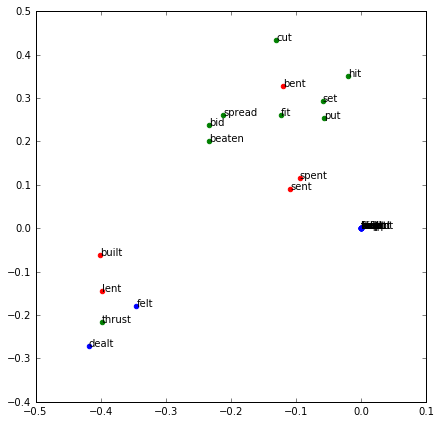

pc=0 pc1=2


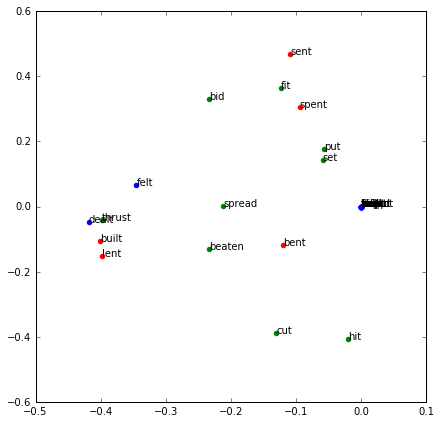

pc=0 pc1=3


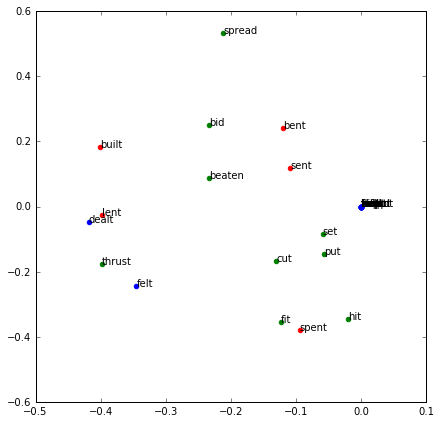

pc=1 pc1=2


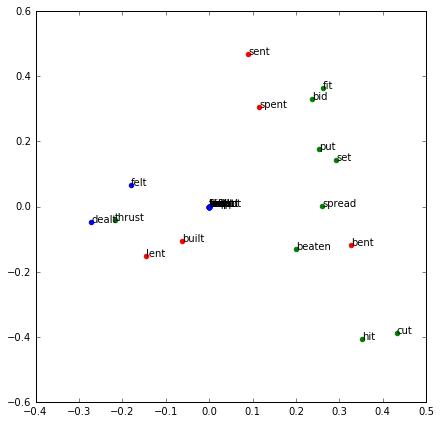

pc=1 pc1=3


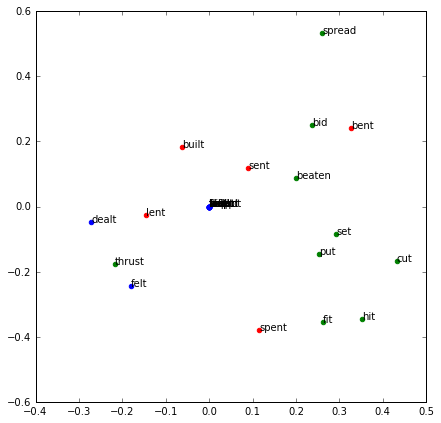

pc=2 pc1=3


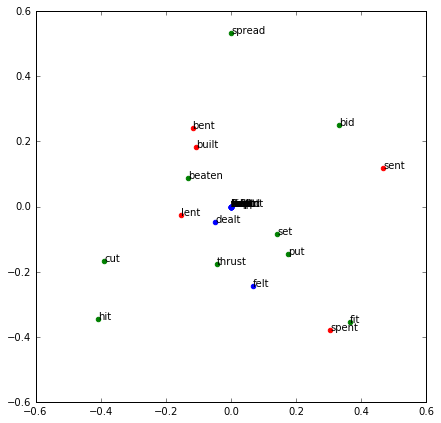

ngram_length 3
(30, 1000)
((30, 30), (30,), (1000, 1000))
(30, 4) (4, 4) (4, 1000) (4, 1000)
pc=0 pc1=1


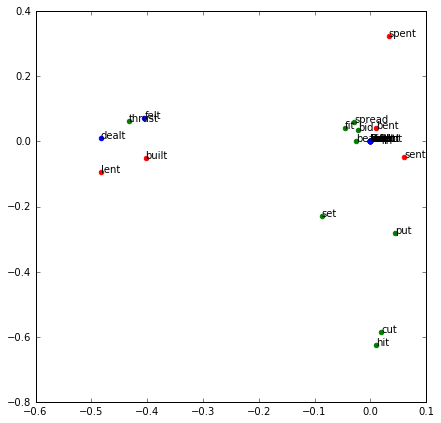

pc=0 pc1=2


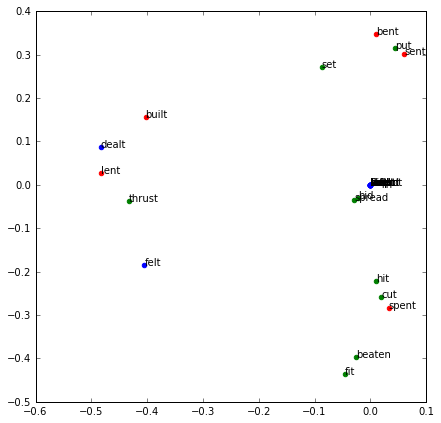

pc=0 pc1=3


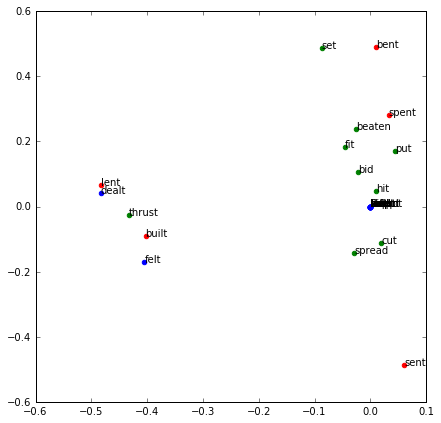

pc=1 pc1=2


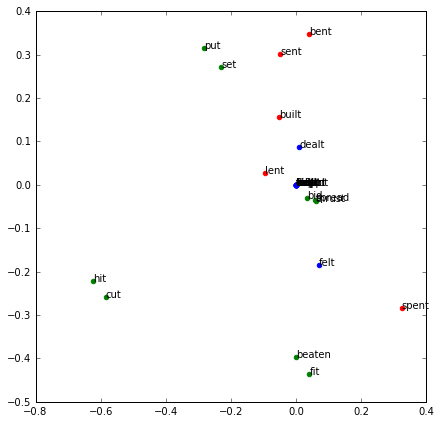

pc=1 pc1=3


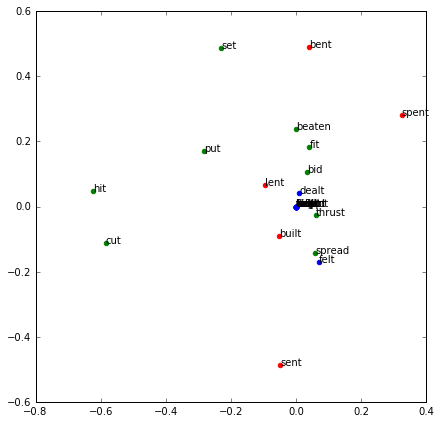

pc=2 pc1=3


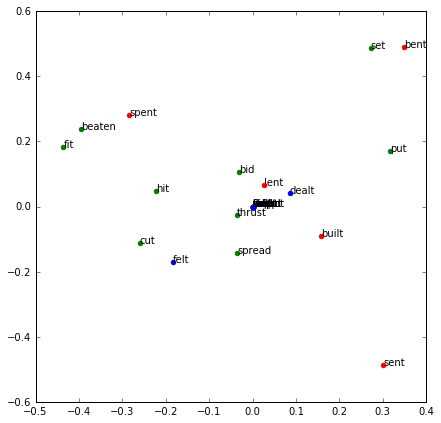

ngram_length 4
(30, 1000)
((30, 30), (30,), (1000, 1000))
(30, 4) (4, 4) (4, 1000) (4, 1000)
pc=0 pc1=1


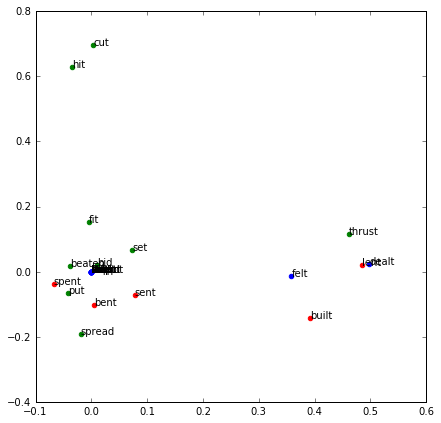

pc=0 pc1=2


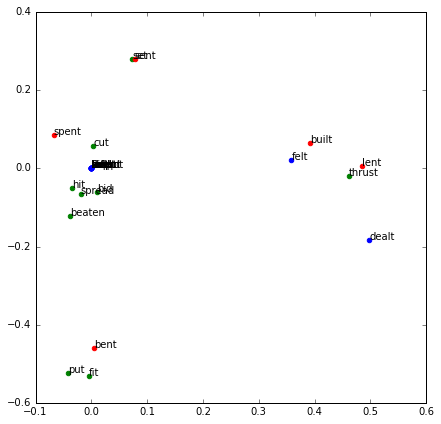

pc=0 pc1=3


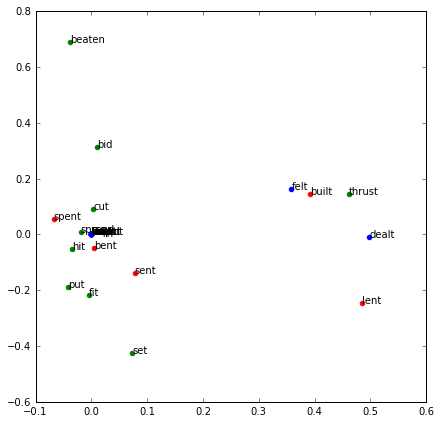

pc=1 pc1=2


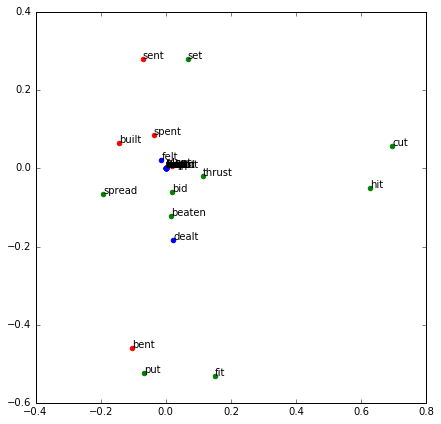

pc=1 pc1=3


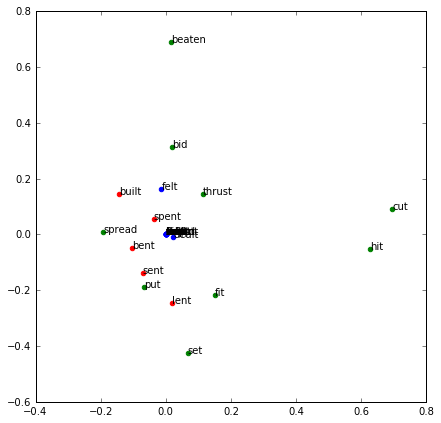

pc=2 pc1=3


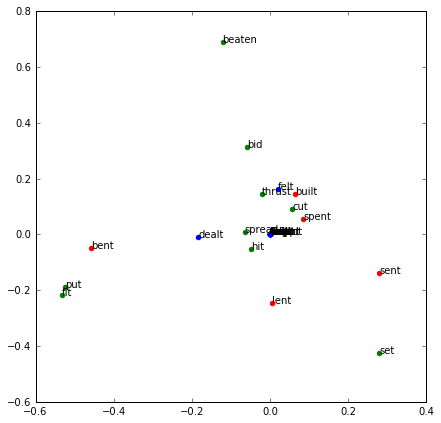

In [61]:
"""
4th dimension. 
Plot pairs of principle components.
"""
for ngram_length in ngram_lengths:
    print "ngram_length %d" % ngram_length
    for c in selected_categories:
        num_subwords = len(category2word[c][0])
        for i in range(num_subwords):
            data_matrix[i] = ngram_encode_cl(category2word[c][1][i], RI_past, ngram_length) - ngram_encode_cl(category2word[c][0][i], RI_pres, ngram_length)
    print data_matrix.shape
    
    ds = [4]

    U, s, V = np.linalg.svd(data_matrix, full_matrices=True)
    print (U.shape, s.shape, V.shape) 
    pca_data = []
    
    for d in ds:
        Ud = U[:, :d]
        Sd = s[:d]*np.eye(d)
        Vd = V[:d, :]
        SdVd = np.dot(Sd, Vd)
        print Ud.shape, Sd.shape, Vd.shape, SdVd.shape
        pca_data.append(Ud)
    
    # 2d plot
    num_dims = len(ds)
    for di in range(num_dims):
        for pc in range(ds[di]):
            for pc1 in range(pc+1,ds[di]):    
                print "pc=" + str(pc) + " pc1=" + str(pc1)
                ud = np.vstack((pca_data[di][:,pc],pca_data[di][:,pc1])).T

                i = 0
                fig, ax = plt.subplots(figsize=(7,7))
                for c in selected_categories:
                    for txt in category2word[c][1]:
                        ax.annotate(txt, (ud[i,0], ud[i,1]))
                        ax.scatter(ud[i,0], ud[i,1], color=available_colors[c])
                        i += 1
                plt.show()
                    